# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [2]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from sklearn.model_selection import train_test_split

#My imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (HalvingGridSearchCV, cross_val_score, KFold)
from sklearn.ensemble import RandomForestRegressor





In [3]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

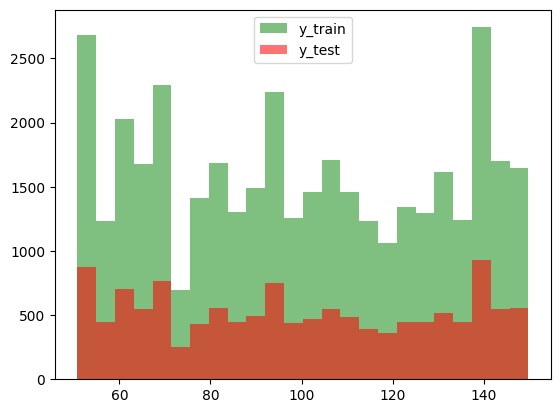

In [4]:
#TODO: visualiser y_train og y_test i et histogram
bins = np.linspace(y_train.min(), y_train.max(), 25)
plt.hist(y_train, bins, alpha=0.5, label="y_train", color="green")
plt.hist(y_test, bins, alpha=0.55, label="y_test", color="red")
plt.legend(loc="upper center")
plt.show()


**Svar:**

Regresjons problemer viser typisk kontinuerlige verdier over x aksen, i motsettning til klassifiserings verdier som viser diskrete verdier som 0, 1, 2 osv. Ved å se på histogrammet over kan en derfor annta at det er et regresjons problem vi støter på her.

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [5]:
def korrelasjonsmatrise(X,y):
    X_temp : pd.DataFrame = X.copy()
    y_temp : pd.Series = y.copy()
    X_temp["Target"] = y_temp

    #Create the correlation matrix using the DataFrame.corr() method
    matrix : pd.DataFrame = X_temp.corr()

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = ax.imshow(matrix, cmap="coolwarm", interpolation="nearest")
    
    #Add colorbar to the plot
    fig.colorbar(im)

    #Create readable labels for the heat map
    columns : list[str] = list(matrix.columns.values)
    for i in range(len(columns)):
        columns[i] = columns[i].replace("_", " ").title()

    #Add x and y labels, rotating the x labels for readability
    ax.set_xticks(np.arange(len(columns)), labels=columns)
    ax.set_yticks(np.arange(len(columns)), labels=columns)
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right")
    
    #Add annotation to each square
    for i in range(len(columns)):
        for j in range(len(columns)):
            text = ax.text(j, i, f"{matrix.iat[i, j]:.2f}", ha="center", va="center", color="black", )

    plt.show()



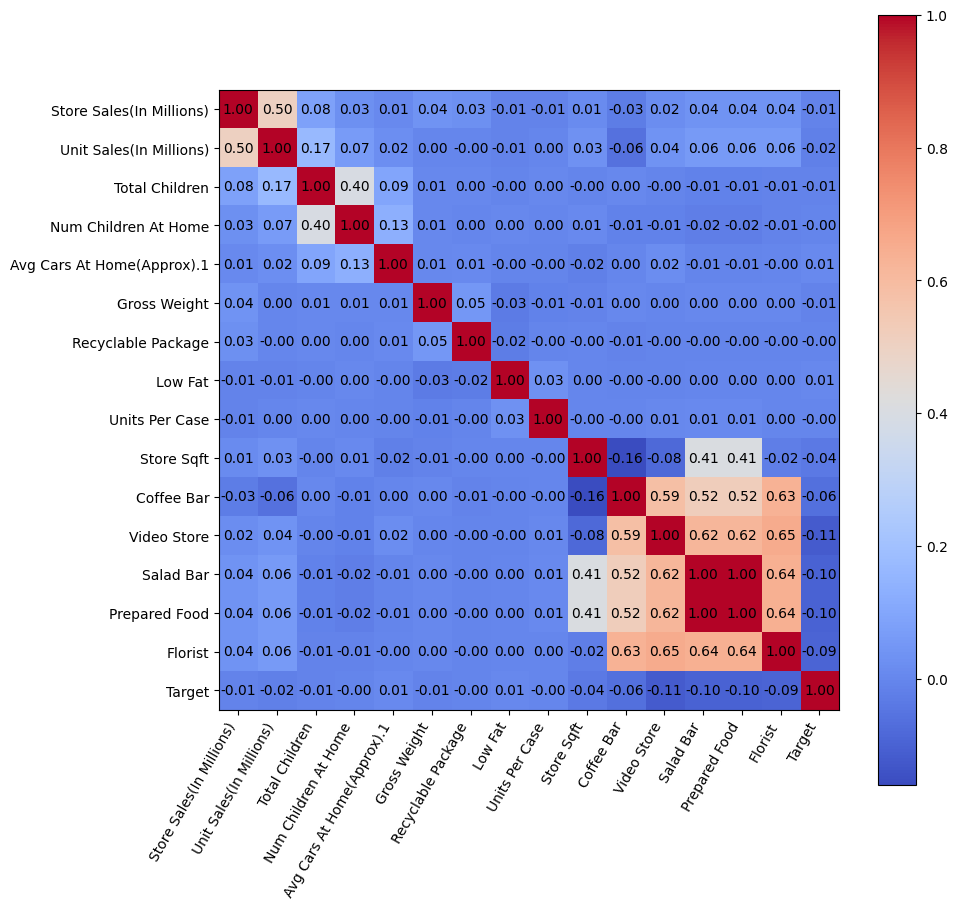

In [6]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**

Høyere vedri i matrixen vil si mer positiv korrelasjon, lavere verdi vil si med negativ korrelasjon.

Ut ifra matrixen kan vi se at egenskapen med høyest positiv korrelasjon med Target er "Avg Cars At Home" og "Low Fat", der de begge ligger på 0.01.

Egenskapene med mest negativ korrelasjon er "Video Store", "Salad Bar", og "Prepared Food" med verdi på -0.11, -0.10 og, -0.10

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [7]:
RAND_STATE: int = 12 #Define randstate to be used for all models

def hyper_search(X: pd.DataFrame, y: pd.Series):
	'''
	Hyper Parmameter Search using the RandomForestRegressor model and HalvingGridSearchCV from sklearn.
	'''
	#Define Search parameters used.
	param_grid = { 
		'max_depth': [None, 3, 4, 5, 10, 20],
		'min_samples_split': [2, 5, 10],
		'n_estimators': [10, 25, 50, 75, 100, 150]
	}

	search = HalvingGridSearchCV( #HalvingGridSearchCV is significanly faster than GridSearchCV while giving just as accurate results, but it is experimental...
		estimator= RandomForestRegressor(random_state=RAND_STATE), #use RandomForestRegressor model
		param_grid=param_grid, #Pass the param grid
		scoring='neg_mean_squared_error', #Scoring parameter, "neg_mean_squared_error" as per the assignment 
		cv=3, #Determines the cross-validation splitting strategy, 3-fold is used here as per the assignment
		n_jobs=-1 #How manu jobs to run in parallel, defaults to none. -1 means all available processors. Significantly affects speed
		).fit(X, y) #Fit the search afterwards

	return search.best_params_, search.best_score_
	
params, score = hyper_search(X_train, y_train)
print(f"Params: {params} \nScore: {score:.2f}")


Params: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 150} 
Score: -854.29


**Svar:**

Params viser hvilke av de valgte hyperparametere som presterte best (Lavest neg_mean_squared_error), i dette tilfelle viste deg seg å være:
* max_depth: 4
* min_samples_split: 10
* n_estimators: 150

Som ga scoren: -854.38 ved bruk av neg_mean_squared_error, her er lavere tall bedre.

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [8]:
#TODO: Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error
def crossvalidation(X: pd.DataFrame, y: pd.Series, params: dict, K: int = 5) -> list:
	'''
	Performs crossvalidation on X and y with the specified parameters, these should be the best parameters found
	 using a hyperparameter search funtion. Logs the result of each crossvalidation round
	'''
	#Define both the model used and KFold, here K>=5 as per the assignment
	rfr = RandomForestRegressor(random_state=RAND_STATE, **params) #Deconstruct the parameters from the hyperparameter search and apply them to the model
	kf =KFold(n_splits=K, shuffle=True, random_state=RAND_STATE)

	#Perform crossevauation using neg_mean_squared_error for scoring
	mse_scores : np.ndarray = cross_val_score(rfr, X, y, cv = kf, scoring="neg_mean_squared_error", n_jobs=-1, verbose=0)
	#Perform crossevauation using neg_mean_absolute_error for scoring
	mae_scores : np.ndarray = cross_val_score(rfr, X, y, cv = kf, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0)

	for i in range(len(mae_scores)):
		#Neg_mean_squared_error had to be used for scoring, inverting the result here turnes the scores into just mean_squared_error.
		# The same is done to Neg_mean_absolute_error
		mae_scores[i] = -mae_scores[i]
		mse_scores[i] = -mse_scores[i]
		#Logs all mae and mse for each crossvalidation round
		print(f"Round {i+1} ->   MSE: {mse_scores[i]:.2f} | MAE: {mae_scores[i]:.2f}")

	return mae_scores, mse_scores

mae_scores, mse_scores = crossvalidation(X_train, y_train, params)


Round 1 ->   MSE: 859.45 | MAE: 25.35
Round 2 ->   MSE: 847.64 | MAE: 25.09
Round 3 ->   MSE: 857.27 | MAE: 25.25
Round 4 ->   MSE: 857.17 | MAE: 25.28
Round 5 ->   MSE: 846.19 | MAE: 25.05


In [15]:
#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
# gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

#Calculate mean/average and standard deviation for both MAE and MSE
mae_avg = np.mean(mae_scores)
mae_std = np.std(mae_scores)
mse_avg = np.mean(mse_scores)
mse_std = np.std(mse_scores)

#Print the results... duh
print(f"Mean Absolute Error ->\tMean: {mae_avg:.2f} | Standard Deviation: \u00B1{mae_std:.2f} or \u00B1{mae_std*100/mae_avg:.2f}%")
print(f"Mean Sqared Error   ->\tMean: {mse_avg:.2f} | Standard Deviation: \u00B1{mse_std:.2f} or \u00B1{mse_std*100/mse_avg:.2f}%")

#Calculate difference between predicted target and actual target in percent
print(f"Predicted-/Actual Mean Percent: {(mae_avg*100/np.mean(y_train)):.2f}%")


Mean Absolute Error ->	Mean: 25.21 | Standard Deviation: ±0.12 or ±0.46%
Mean Sqared Error   ->	Mean: 853.55 | Standard Deviation: ±5.49 or ±0.64%
Predicted-/Actual Mean Percent: 25.37%


**Svar:**

Gjennomsnittet(Mean) forteller oss om ytelsen til modellen, mens standardaviket(Standard Deviation) forteller oss om presisjonen til modellen, altså hvor stor variasjonen det er. Når standard deviation er +- 0.46% så kan vi forventet at resultatet vi får ligger immelom det. 

Sammenligningen med faktisk pris lar oss bedre forstå hvor nøyaktig modellen vår faktsik er.



#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [10]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene

#Define the model used and use the parameters from the hyperparameter search done earlier, then fit the model to our training data
rfr = RandomForestRegressor(random_state=RAND_STATE, **params).fit(X_train, y_train)
prediction = rfr.predict(X_test) #Perform a prediction using our model on the test data

#Calculate MSE and MAE
mse = np.mean(np.square(y_test - prediction))
mae = np.mean(np.abs(y_test - prediction))

print(f"Mean Sqared Error   ->\tMean: {mse:.2f}")
print(f"Mean Absolute Error ->\tMean: {mae:.2f}")

#Calculate and print difference between predicted target and actual target in percent
print(f"\nPredicted-/Actual Mean Percent: {(mae*100/np.mean(y_train)):.2f}%")




Mean Sqared Error   ->	Mean: 855.75
Mean Absolute Error ->	Mean: 25.29

Predicted-/Actual Mean Percent: 25.46%


**Svar:**

Gjennomsnittlige feilen på prediksjonen sammenlignet med de gjennomsnittlige faktiske prisene i testdataene har en prosent feil på 25.46%, en lavere verdi her vil si at modellen er mer presis. 

Ettersom 25.46% er en ganske høy prosent feil vil jeg si at modellen her er ganke upresis.
